Camera Calibration
===

In [55]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from moviepy.editor import VideoFileClip
from collections import deque

YM_PER_PIX = 30/720
XM_PER_PIX = 3.7/700 

In [56]:
def showImagesSideBySide(original, modified, cvtColorOriginal= "BGR2RGB", cvtColorModified = "gray"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    fig.tight_layout()
    
    if cvtColorOriginal == "BGR2RGB":
        ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    elif cvtColorOriginal == "gray":
        ax2.imshow(original, cmap='gray')
    else:
        ax2.imshow(original)
        
    ax1.set_title('Original', fontsize=20)
    
    if cvtColorModified == "BGR2RGB":
        ax2.imshow(cv2.cvtColor(modified, cv2.COLOR_BGR2RGB))
    elif cvtColorModified == "gray":
        ax2.imshow(modified, cmap='gray')
    else:
        ax2.imshow(modified)
    
    ax2.set_title('Binary', fontsize=20)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [57]:
class Camera:
    
    def __init__(self):
        pass
    
    def calibrateCamera(self, p_fileNameImages, p_nx, p_ny, p_imgSize):
    
        width = p_imgSize[0]
        height = p_imgSize[1]

        # objpoints will hold the 3D points in real world space.
        # since we know the concrete chessboard image, we also know the coordinates
        # z will be always zero, since the chessboard is on a plane
        # objpoints is the SAME for all images
        objPointsAllImages = []

        # imgpoints holds the 2D points in image plane (the distorted image)
        imgPointsAllImages = []

        # prepare object points
        objPointsSingleImage = np.zeros((p_nx * p_ny, 3), np.float32)
        objPointsSingleImage[:, :2] = np.mgrid[0:p_nx, 0:p_ny].T.reshape(-1, 2)

        for fname in p_fileNameImages:
            imgPointsSingleImage = self.getImagePoints(fname, p_nx, p_ny, p_imgSize);
            if len(imgPointsSingleImage) > 0:
                objPointsAllImages.append(objPointsSingleImage)
                imgPointsAllImages.append(imgPointsSingleImage[0])

        imgPointsAllImages = np.array(imgPointsAllImages)
        objPointsAllImages = np.array(objPointsAllImages)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPointsAllImages, imgPointsAllImages, (height, width), None, None)
        
        self.mtx = mtx
        self.dist = dist
        
    def getImagePoints(self, p_fname, p_nx, p_ny, p_imgSize):

        img = cv2.imread(p_fname)

        # imgpoints holds the 2D points in image plane (the distorted image)
        imgpoints = [] 

        resizedImage = cv2.resize(img, p_imgSize)

        # find the chessboard corners
        gray = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (p_nx, p_ny), None)

        # if corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
        else:
            print('No corners detected in: ', p_fname)


        return imgpoints
    
    def undistort(self, image_BGR):
        undistorted = cv2.undistort(image_BGR, self.mtx, self.dist, None, self.mtx )
        return undistorted

In [ ]:
images = glob.glob('./camera_cal/calibration*.jpg')

camera = Camera()
camera.calibrateCamera(images, 9, 6, (1280, 720))

In [ ]:
distorted = cv2.imread('./camera_cal/calibration2.jpg')
undistorted = camera.undistort(distorted)
distorted = cv2.cvtColor(distorted, cv2.COLOR_BGR2RGB)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(24, 9))
fig.add_subplot(121), plt.imshow(distorted), plt.title('Distorted'), plt.axis('off')
fig.add_subplot(122), plt.imshow(undistorted), plt.title('Undistorted'), plt.axis('off')
plt.show()

In [58]:
images = glob.glob('./test_images/*.jpg')

In [59]:
for fname in images:
    filenameStartIndex = fname.index('/', 2)
    distorted = cv2.imread(fname)
    undistorted = camera.undistort(distorted)
    cv2.imwrite('./test_images_undistorted' + fname[filenameStartIndex:], undistorted)

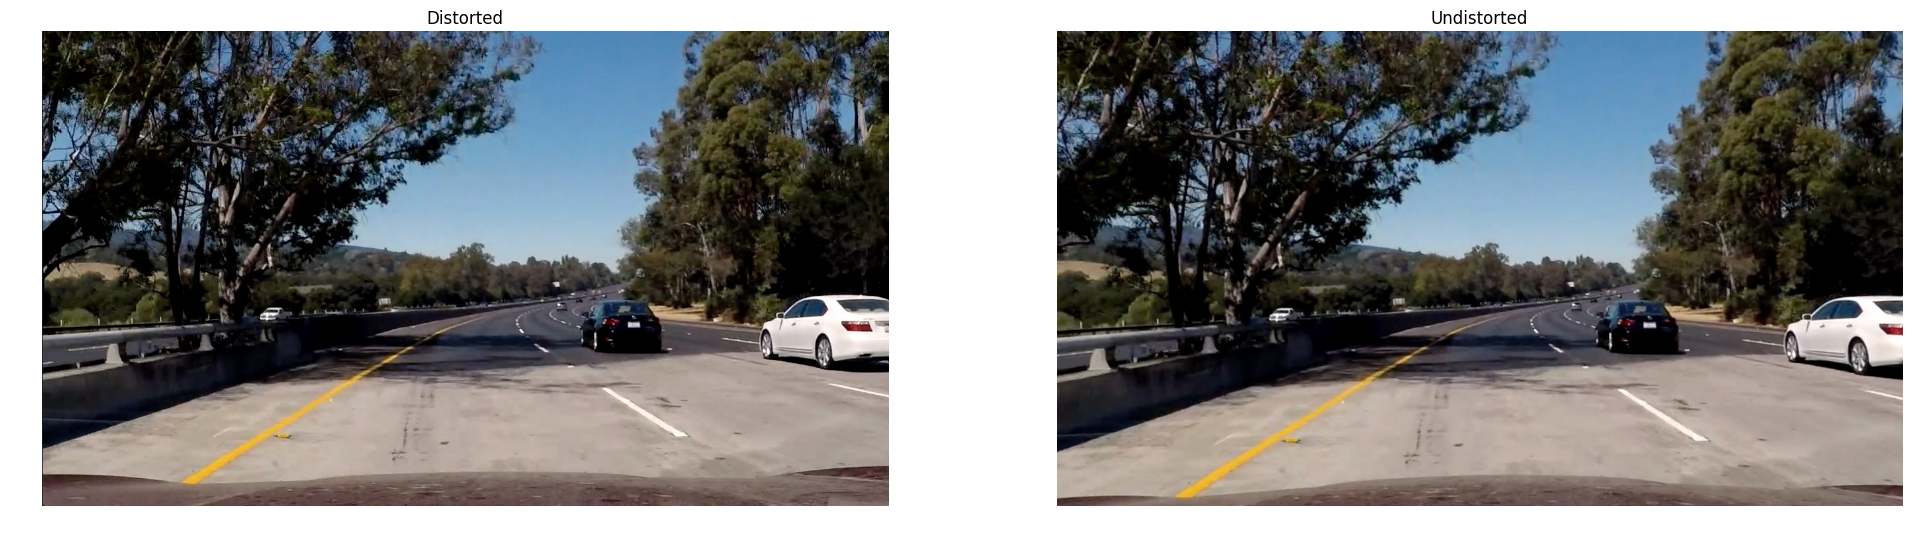

In [60]:
distorted = cv2.imread('./test_images/test5.jpg')
undistorted = cv2.imread('./test_images_undistorted/test5.jpg')
distorted = cv2.cvtColor(distorted, cv2.COLOR_BGR2RGB)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(24, 9))
fig.add_subplot(121), plt.imshow(distorted), plt.title('Distorted'), plt.axis('off')
fig.add_subplot(122), plt.imshow(undistorted), plt.title('Undistorted'), plt.axis('off')
plt.show()

In [33]:
# %load transformations.py
class PerspectiveTransform:
    
    def __init__(self):
        
        top_left = (588 , 454)
        top_right = (696 , 454)
        bottom_right = (1049, 684)
        bottom_left = (269, 684)

        self.src_points = np.float32([
                (588 , 454),    # top_left
                (696 , 454),    # top_right
                (1049, 684),    # bottom_right 
                (269, 684)])    # bottom_left

        self.dst_points = np.float32([
                (320, 0),       # top_left
                (960, 0),       # top_right
                (960, 720),     # bottom_right
                (320, 720)])    # bottom_left

        self.M = cv2.getPerspectiveTransform(self.src_points, self.dst_points)
        self.invM = cv2.getPerspectiveTransform(self.dst_points, self.src_points)

    def toBirdsEyeView(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]))
    
    def toCarCameraView(self, img):
        return cv2.warpPerspective(img, self.invM, (img.shape[1], img.shape[0]))
    
    def getSrcPoints(self):
        return self.src_points
    
    def getDstPoints(self):
        return self.dst_points

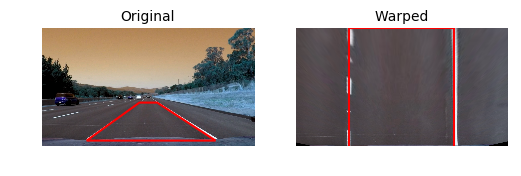

In [34]:
pt = PerspectiveTransform()
image3 = cv2.imread('./test_images/straight_lines2.jpg')

warped = pt.toBirdsEyeView(image3)   

f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(image3), ax1.set_title('Original',fontsize=10),
ax1.set_axis_off()   
poly = patches.Polygon(pt.getSrcPoints(), True, fill= False, linewidth = 1.5, color = 'r')
ax1.add_patch(poly)
ax2.imshow(warped), ax2.set_title('Warped', fontsize=10),
poly = patches.Polygon(pt.getDstPoints(), True, fill= False, linewidth = 1.5, color = 'r')
ax2.set_axis_off()   
ax2.add_patch(poly)
plt.show()

In [61]:
images = glob.glob('./test_images/*.jpg')
pt = PerspectiveTransform()

for fname in images:
    filenameStartIndex = fname.index('/', 2)
    distorted = cv2.imread(fname)
    undistorted = camera.undistort(distorted)
    transformed = pt.toBirdsEyeView(undistorted)
    cv2.imwrite('./test_images_perspective/' + fname[filenameStartIndex:], transformed)

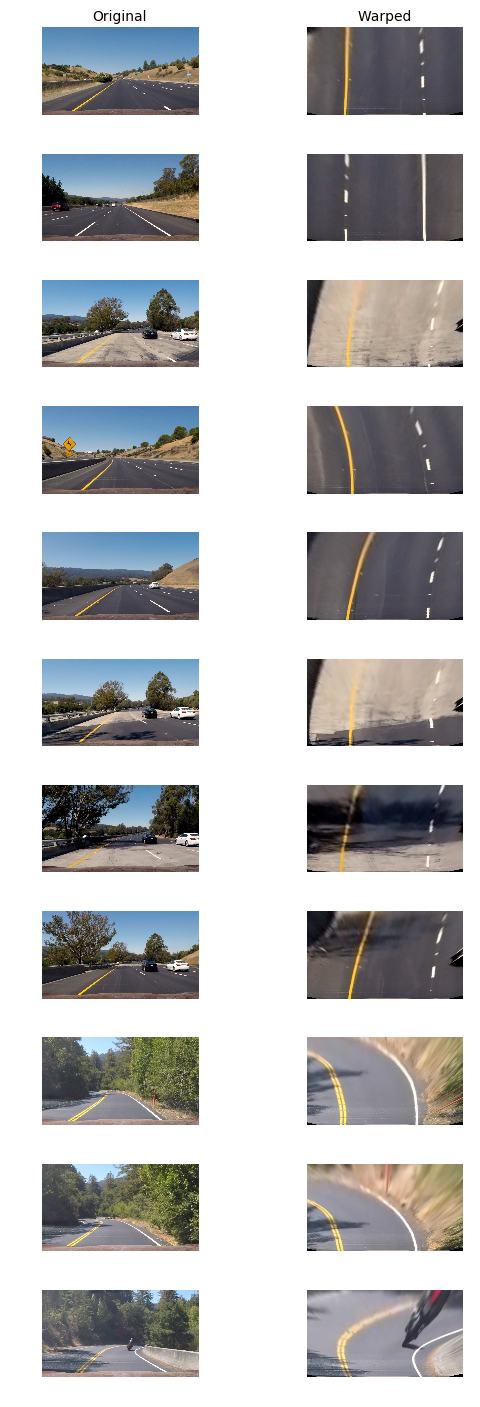

In [35]:
def visualizePerspectiveTransformation(ax, image_BGR, header = False):
    
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    warped = pt.toBirdsEyeView(image_RGB)

    ax[0].set_axis_off()    
    ax[0].imshow(image_RGB)
    if header:
        ax[0].set_title('Original', fontsize=10)
    
    ax[1].set_axis_off()
    ax[1].imshow(warped)
    if header:
        ax[1].set_title('Warped', fontsize=10)


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(11, 2, figsize=(10, 15))
fig.tight_layout()
visualizePerspectiveTransformation(ax1, cv2.imread('./test_images/straight_lines1.jpg'), True)
visualizePerspectiveTransformation(ax2, cv2.imread('./test_images/straight_lines2.jpg'))
visualizePerspectiveTransformation(ax3, cv2.imread('./test_images/test1.jpg'))
visualizePerspectiveTransformation(ax4, cv2.imread('./test_images/test2.jpg'))
visualizePerspectiveTransformation(ax5, cv2.imread('./test_images/test3.jpg'))
visualizePerspectiveTransformation(ax6, cv2.imread('./test_images/test4.jpg'))
visualizePerspectiveTransformation(ax7, cv2.imread('./test_images/test5.jpg'))
visualizePerspectiveTransformation(ax8, cv2.imread('./test_images/test6.jpg'))
visualizePerspectiveTransformation(ax9, cv2.imread('./test_images/harder_challenge_video-0.jpg'))
visualizePerspectiveTransformation(ax10, cv2.imread('./test_images/harder_challenge_video-1.jpg'))
visualizePerspectiveTransformation(ax11, cv2.imread('./test_images/harder_challenge_video-5.jpg'))
plt.subplots_adjust(left=0., right=0.5, top=0.9, bottom=0.)
plt.show()

In [36]:
class ColorThresholding:
    
    def __init__(self):
        pass

    def extractYellow(self, image_BGR, min_thresh=(28,28,50), max_thresh=(58,100,100)):        
        return self._thresholdColor(image_BGR, min_thresh, max_thresh)


    def extractWhite(self, image_BGR, min_thresh=(20,0,75), max_thresh=(360,10,100)):
        return self._thresholdColor(image_BGR, min_thresh, max_thresh)
    
    
    def extractWhiteAndYellow(self, image_BGR):
        yellow = self.extractYellow(image_BGR)
        white = self.extractWhite(image_BGR)
        yellow_and_white = np.zeros_like(yellow)
        filter = (yellow > 0) | (white > 0)
        yellow_and_white[filter] = 1
        return yellow_and_white

    
    def _thresholdColor(self, image_BGR, min_thresh, max_thresh):
    
        min_thresh_normalized = (min_thresh[0] * 0.7, min_thresh[1] * 2.55, min_thresh[2] * 2.55)
        max_thresh_normalized = (max_thresh[0] * 0.7, max_thresh[1] * 2.55, max_thresh[2] * 2.55)

        image_HSV = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2HSV).astype(np.float)
        hsv_filtered = cv2.inRange(image_HSV, min_thresh_normalized, max_thresh_normalized)

        # return value contains 0 and 255 as values
        return hsv_filtered

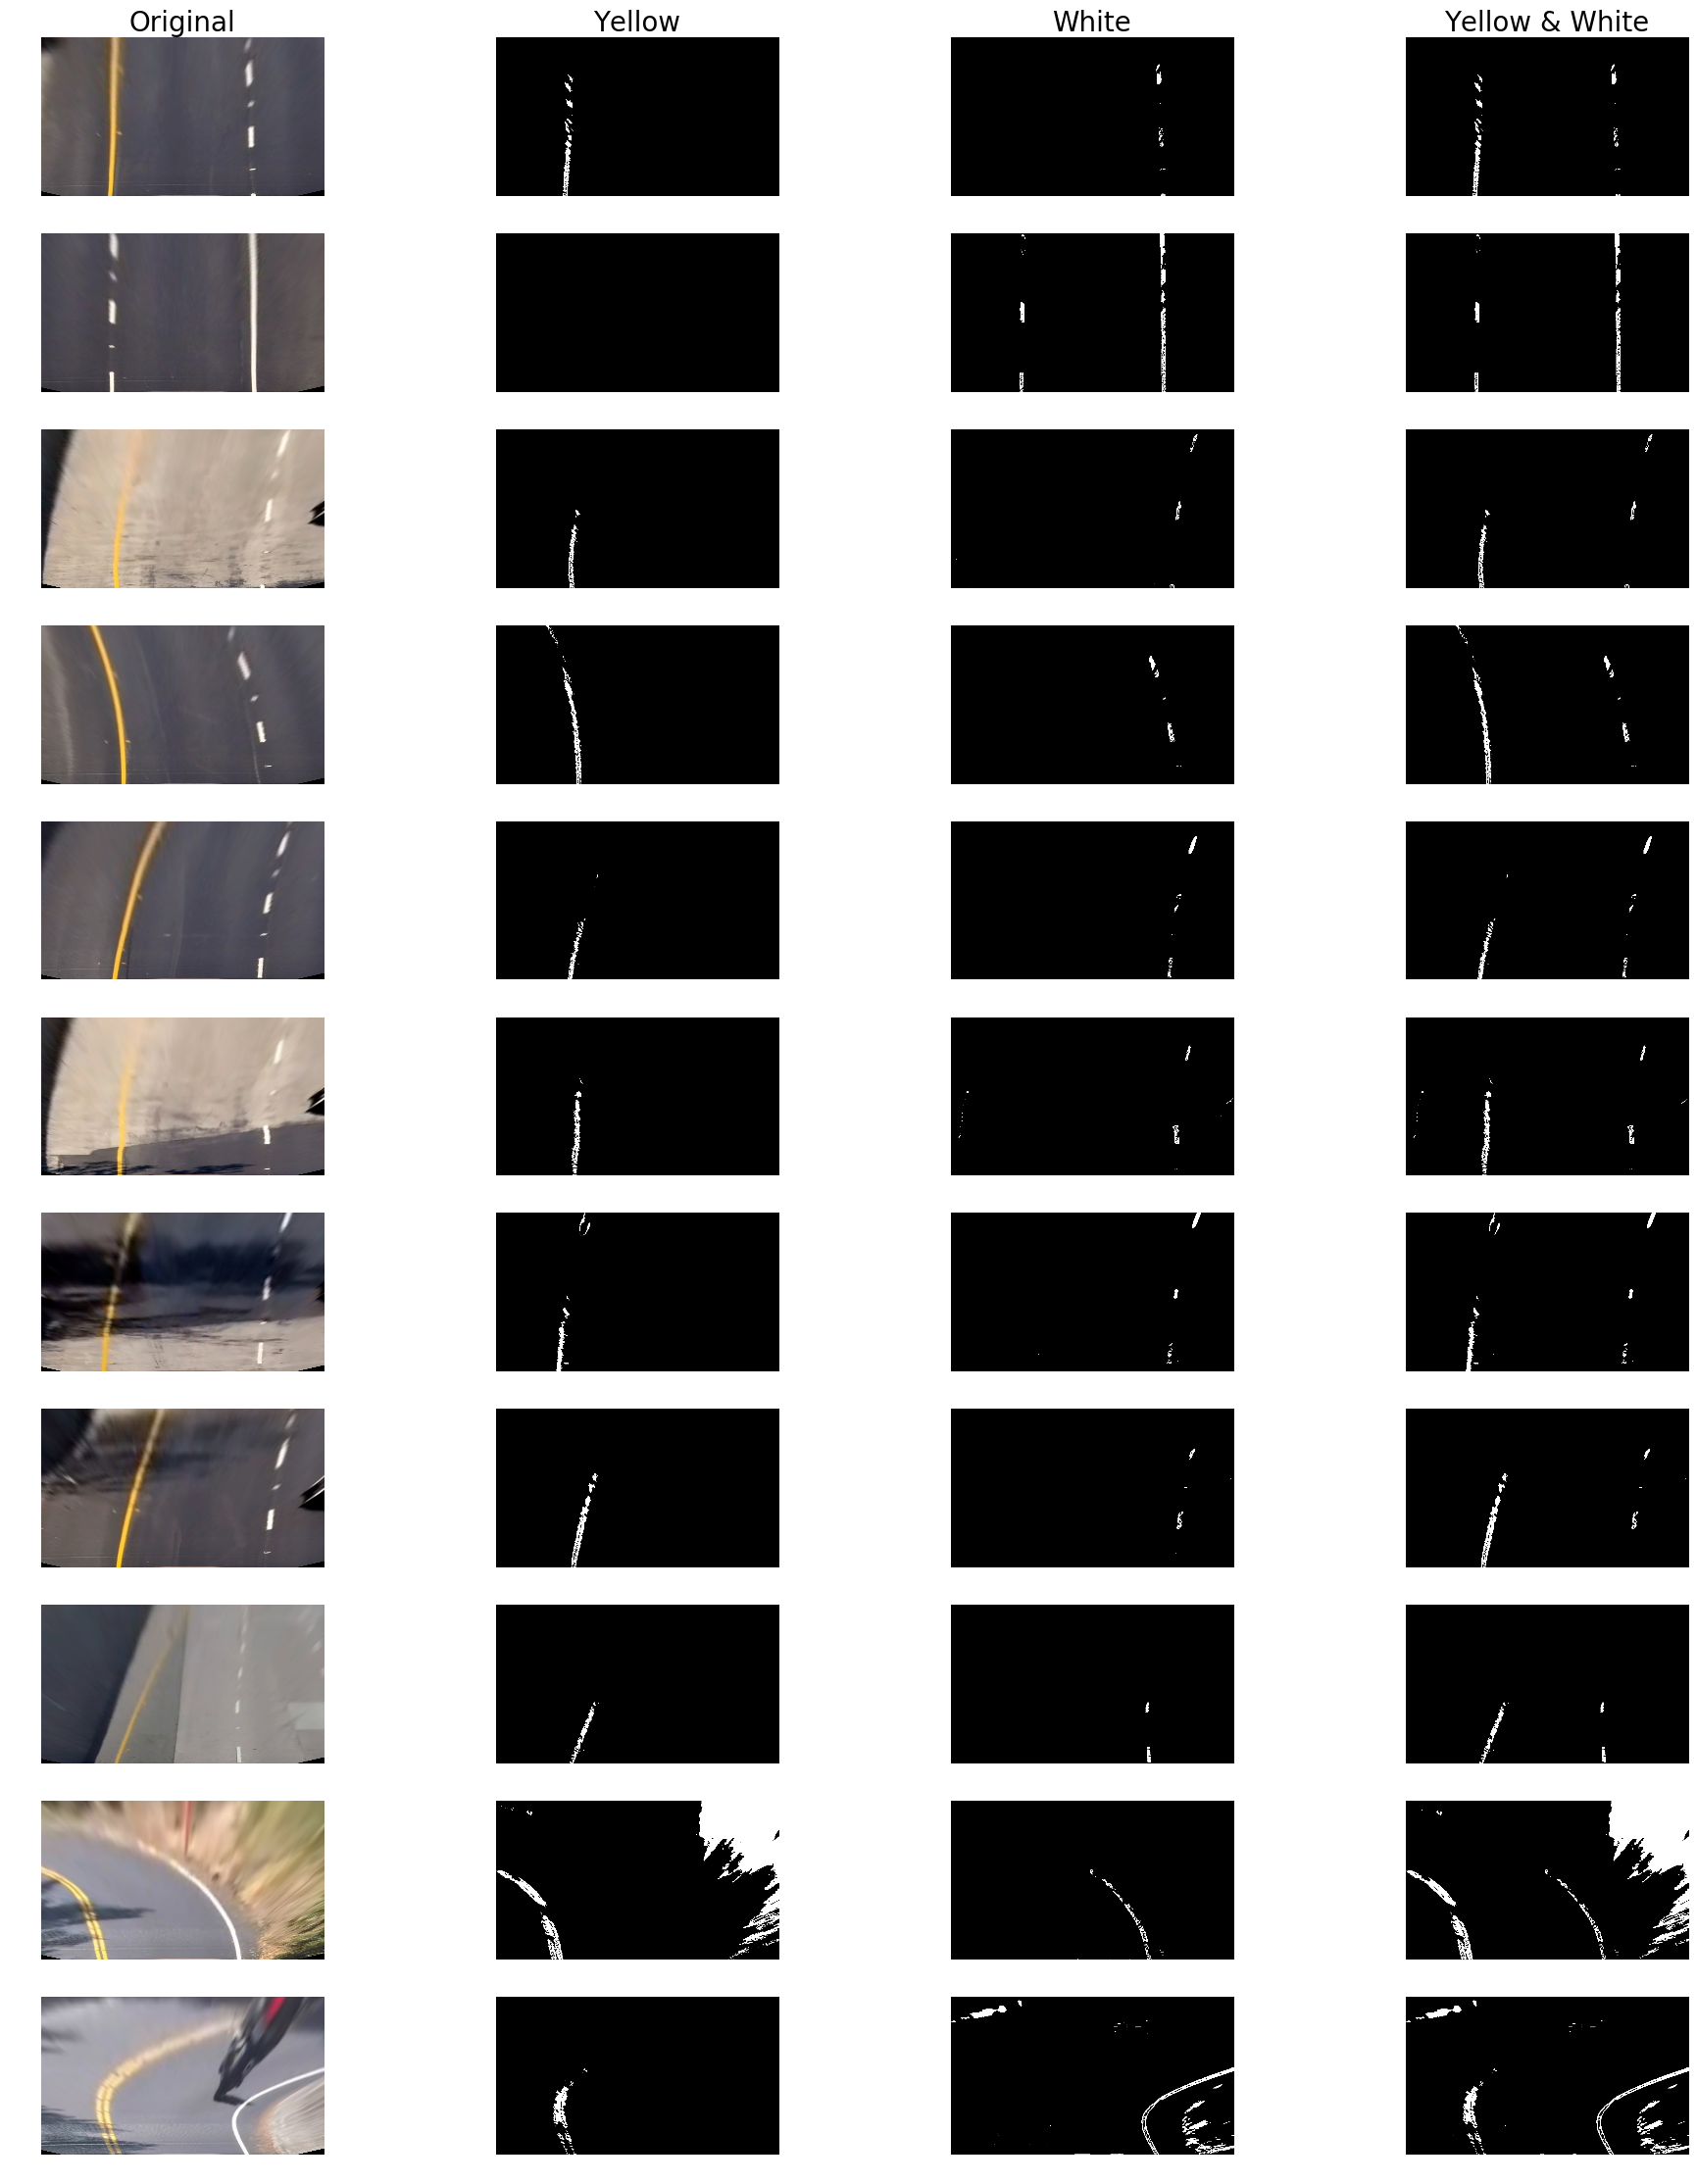

In [62]:
def visualizeColorThresholding(ax, image_BGR, header = False):
    ct = ColorThresholding()
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    image_WY = cv2.GaussianBlur(ct.extractWhiteAndYellow(image_BGR), (3,3),0)
    image_W = ct.extractWhite(image_BGR)
    image_Y = ct.extractYellow(image_BGR)

    ax[0].set_axis_off()    
    ax[0].imshow(image_RGB)
    if header:
        ax[0].set_title('Original', fontsize=20)
    
    ax[1].set_axis_off()
    ax[1].imshow(image_Y, cmap='gray')
    if header:
        ax[1].set_title('Yellow', fontsize=20)

    ax[2].set_axis_off()
    ax[2].imshow(image_W, cmap='gray')
    if header:
        ax[2].set_title('White', fontsize=20)
    
    ax[3].set_axis_off()
    ax[3].imshow(image_WY, cmap='gray')
    if header:
        ax[3].set_title('Yellow & White', fontsize=20)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(11, 4, figsize=(18, 24))
fig.tight_layout()
visualizeColorThresholding(ax1, cv2.imread('./test_images_perspective/straight_lines1.jpg'), True)
visualizeColorThresholding(ax2, cv2.imread('./test_images_perspective/straight_lines2.jpg'))
visualizeColorThresholding(ax3, cv2.imread('./test_images_perspective/test1.jpg'))
visualizeColorThresholding(ax4, cv2.imread('./test_images_perspective/test2.jpg'))
visualizeColorThresholding(ax5, cv2.imread('./test_images_perspective/test3.jpg'))
visualizeColorThresholding(ax6, cv2.imread('./test_images_perspective/test4.jpg'))
visualizeColorThresholding(ax7, cv2.imread('./test_images_perspective/test5.jpg'))
visualizeColorThresholding(ax8, cv2.imread('./test_images_perspective/test6.jpg'))
visualizeColorThresholding(ax9, cv2.imread('./test_images_perspective/harder_challenge_video-0.jpg'))
visualizeColorThresholding(ax10, cv2.imread('./test_images_perspective/harder_challenge_video-1.jpg'))
visualizeColorThresholding(ax11, cv2.imread('./test_images_perspective/harder_challenge_video-5.jpg'))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [63]:
class SobelThresholding:
    
    def __init__(self):
        pass
    
    def sobel_thresh(self, gray, orient='x', sobel_kernel=3, sobel_thresh=(0, 255)):
    
        if orient == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        if orient == 'y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

        abs_sobel = np.absolute(sobel)

        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        sbinary = np.zeros_like(scaled_sobel)
        filter = (scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])
        sbinary[filter] = 1

        return sbinary

    def mag_thresh(self, gray, sobel_kernel=3, mag_thresh=(0, 255)):

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

        abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))

        scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))

        sbinary = np.zeros_like(scaled_sobel)
        filter = (scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])
        sbinary[filter] = 1

        return sbinary

    def dir_thresh(self, gray, sobel_kernel=3, dir_thresh=(0.7, np.pi/2)):

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

        sbinary =  np.zeros_like(absgraddir)
        filter = (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])
        sbinary[filter] = 1

        return sbinary

In [104]:
class PixelSelection:
    
    def __init__(self):
        self.ct = ColorThresholding()
        self.st = SobelThresholding()

    def detectLanePixels(self, image_BGR):
        colors =self.ct.extractWhiteAndYellow(image_BGR)
        gray = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2GRAY)
        sobel_x = self.st.sobel_thresh(gray, orient='x', sobel_thresh=(25, 120))
        sobel_y = self.st.sobel_thresh(gray, orient='y', sobel_thresh=(25, 120))
        magnitude = self.st.mag_thresh(gray, mag_thresh=(30, 120))
        
        sobel = np.zeros_like(sobel_x)
        combined = np.zeros_like(sobel_x)
    
        sobel[((magnitude == 1) | (sobel_x == 1))] = 1
        sobel[(sobel_y == 1)] = 0

        combined[((colors == 1) & (sobel == 1))] = 1
        
        
        #combined[:, 1100:] = 0
        #combined[:, :180] = 0 
        
        return colors

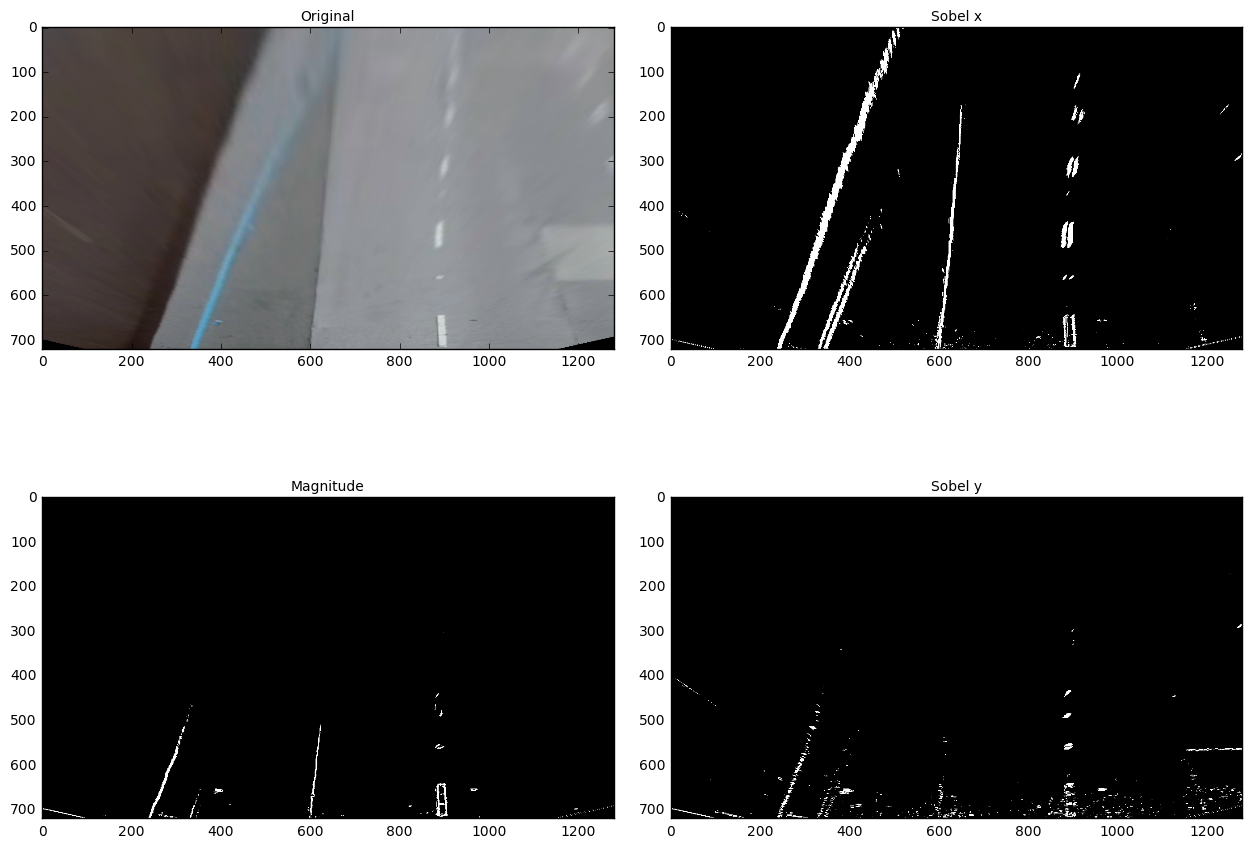

In [102]:
def visualizeSobelThresholding(image_BGR):
    gray = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2GRAY)
    st = SobelThresholding()
    ps = PixelSelection()
    ct = ColorThresholding()  

    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 10))
    fig.tight_layout()
    
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    ax1[0].imshow(image_BGR)
    ax1[0].set_title('Original', fontsize=10)

    sobel_x = st.sobel_thresh(gray, orient='x', sobel_thresh=(15, 120))
    ax1[1].imshow(sobel_x, cmap='gray')
    ax1[1].set_title('Sobel x', fontsize=10)

    magnitude = st.mag_thresh(gray, mag_thresh=(20, 120))
    ax2[0].imshow(magnitude, cmap='gray')
    ax2[0].set_title('Magnitude', fontsize=10)

    sobel_y = st.sobel_thresh(gray, orient='y', sobel_thresh=(10, 120))
    ax2[1].imshow(sobel_y, cmap='gray')
    ax2[1].set_title('Sobel y', fontsize=10)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
test_img = cv2.imread('./test_images_perspective/challenge_video-13.jpg')
visualizeSobelThresholding(test_img)

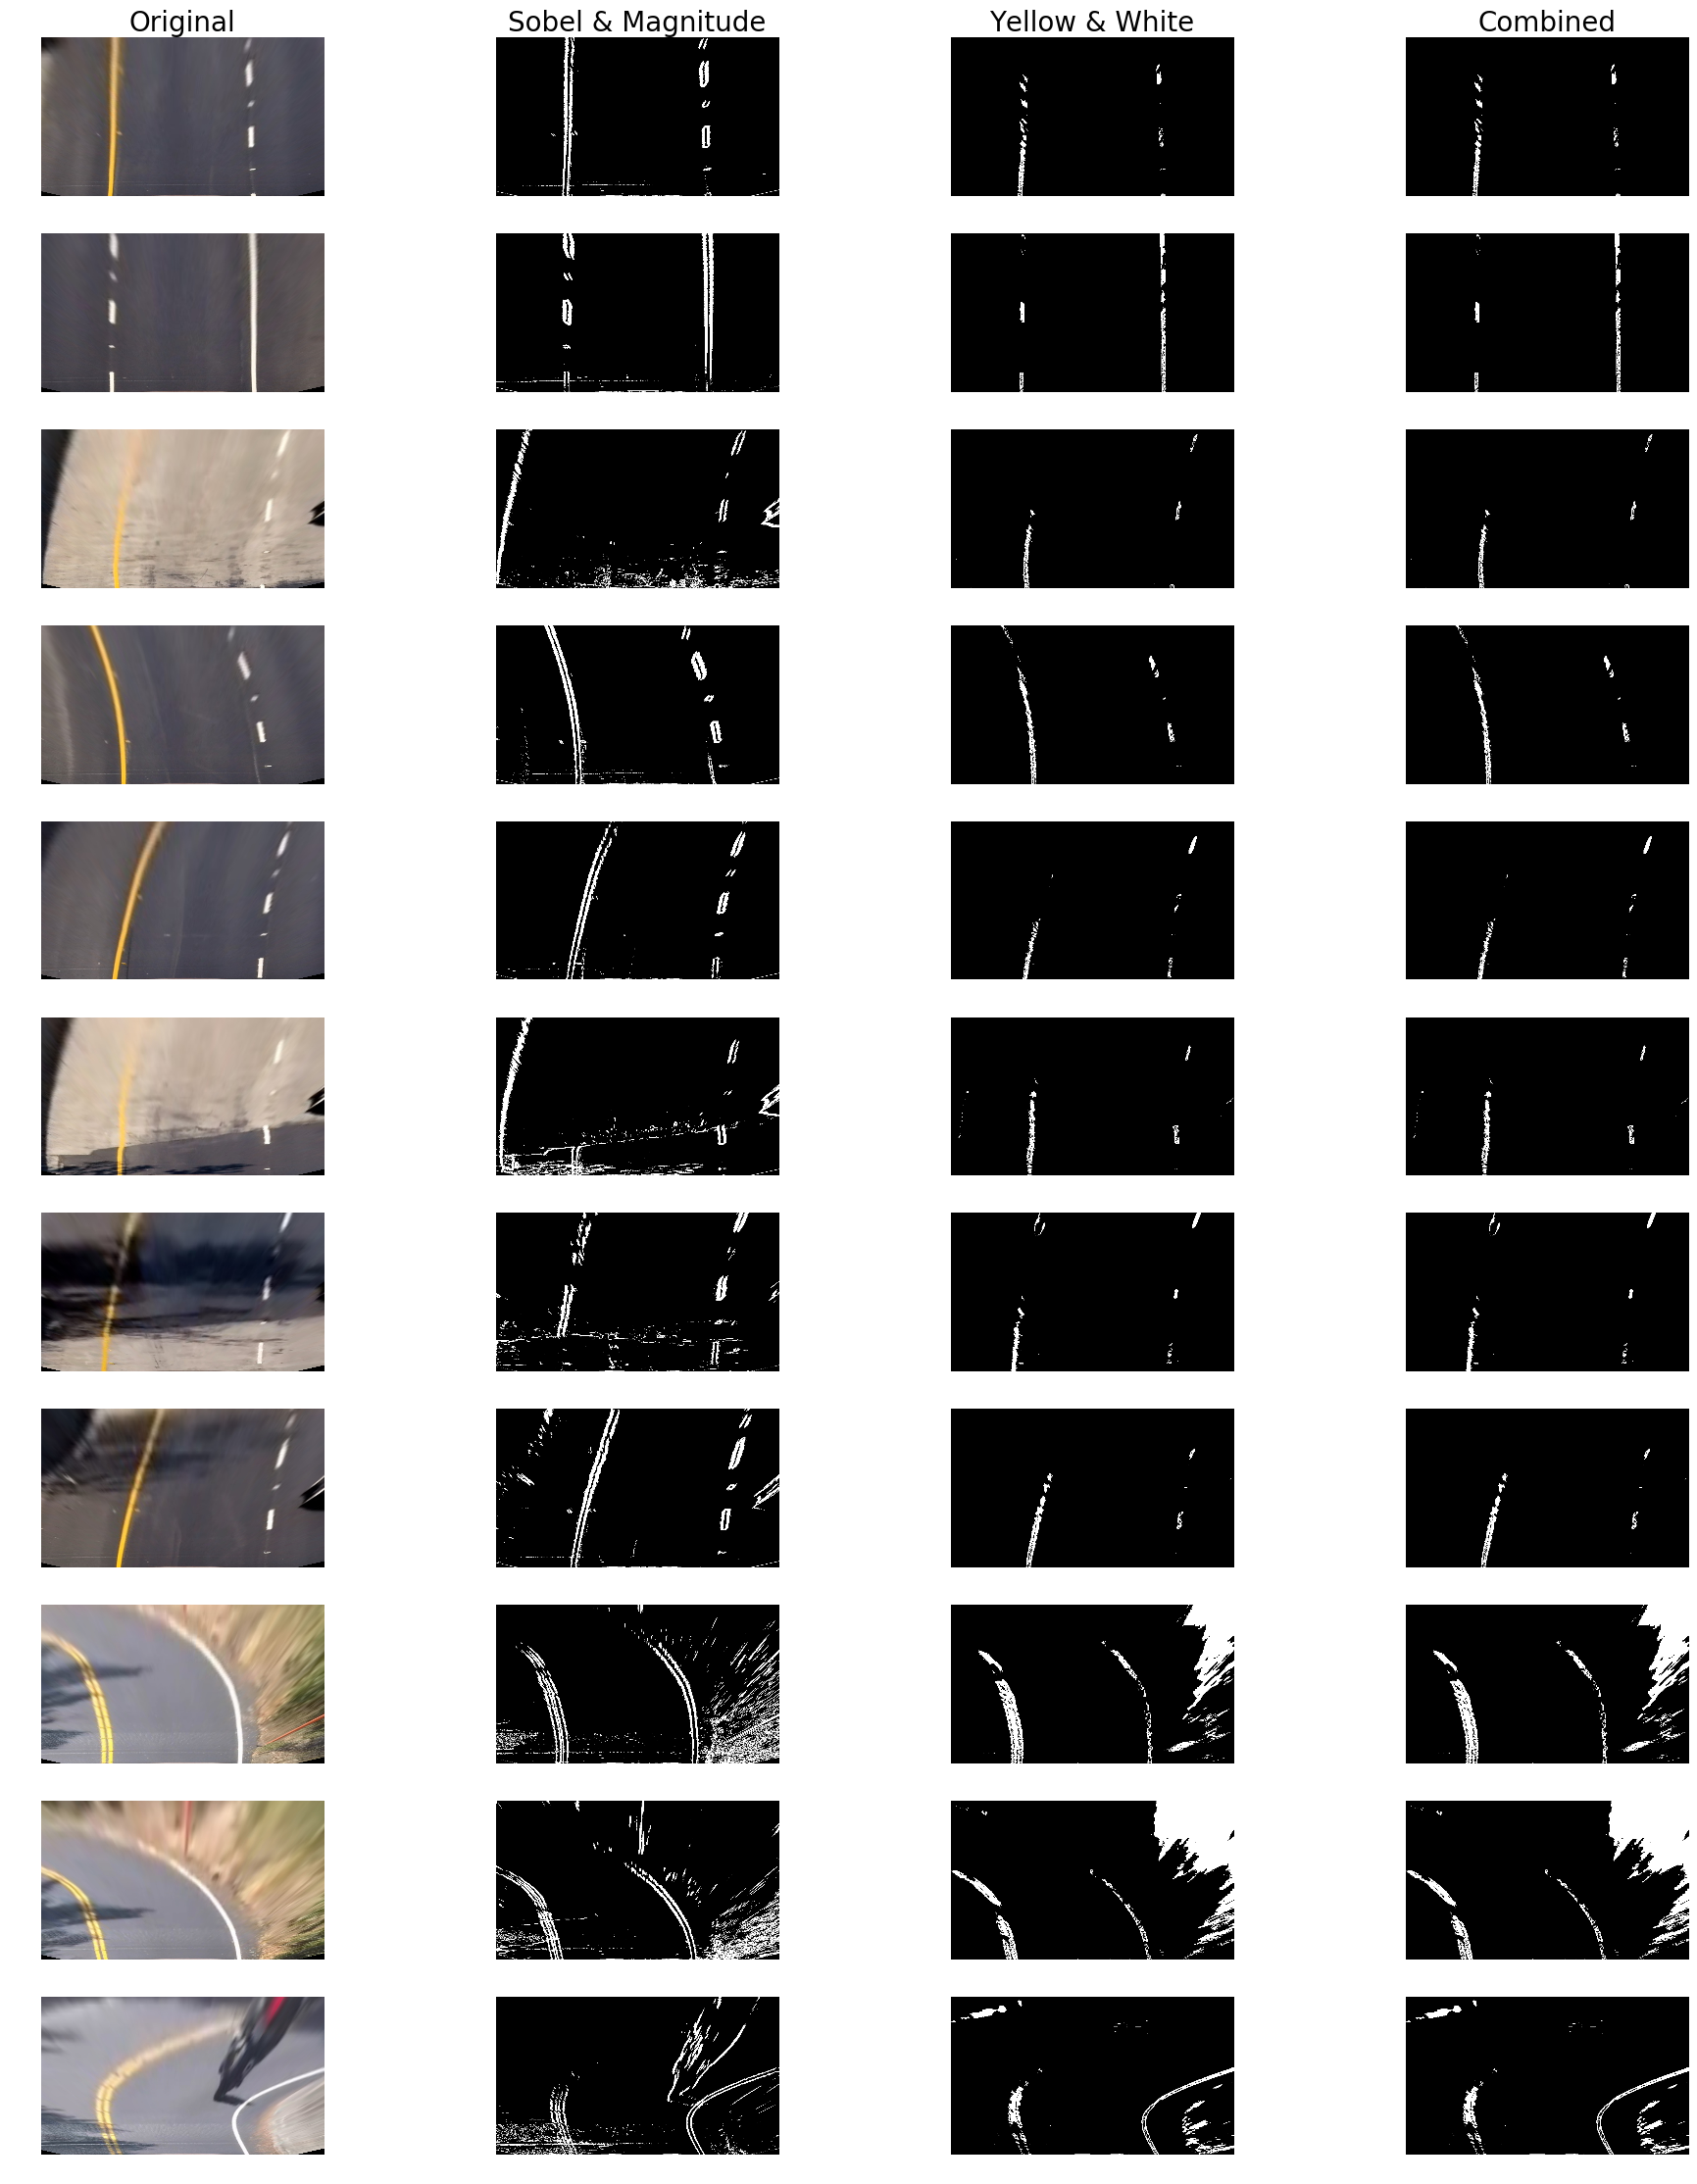

In [103]:
def visualizeCombinedThresholding(ax, image_BGR, header = False):
    ct = ColorThresholding()
    st = SobelThresholding()
    ps = PixelSelection()
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image_RGB, cv2.COLOR_BGR2GRAY)
    sobel_x = st.sobel_thresh(gray, orient='x', sobel_thresh=(15, 120))
    sobel_y = st.sobel_thresh(gray, orient='y', sobel_thresh=(10, 120))
    magnitude = st.mag_thresh(gray, mag_thresh=(20, 120))
        
    gradients = np.zeros_like(sobel_x)
    gradients[((magnitude == 1) | (sobel_x == 1))] = 1
     
    image_WY = ct.extractWhiteAndYellow(image_BGR)
    combined = ps.detectLanePixels(image_BGR)

    ax[0].set_axis_off()    
    ax[0].imshow(image_RGB)
    if header:
        ax[0].set_title('Original', fontsize=20)
    
    ax[1].set_axis_off()
    ax[1].imshow(gradients, cmap='gray')
    if header:
        ax[1].set_title('Sobel & Magnitude', fontsize=20)

    ax[2].set_axis_off()
    ax[2].imshow(image_WY, cmap='gray')
    if header:
        ax[2].set_title('Yellow & White', fontsize=20)
    
    ax[3].set_axis_off()
    ax[3].imshow(combined, cmap='gray')
    if header:
        ax[3].set_title('Combined', fontsize=20)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(11, 4, figsize=(18, 24))
fig.tight_layout()
visualizeCombinedThresholding(ax1, cv2.imread('./test_images_perspective/straight_lines1.jpg'), True)
visualizeCombinedThresholding(ax2, cv2.imread('./test_images_perspective/straight_lines2.jpg'))
visualizeCombinedThresholding(ax3, cv2.imread('./test_images_perspective/test1.jpg'))
visualizeCombinedThresholding(ax4, cv2.imread('./test_images_perspective/test2.jpg'))
visualizeCombinedThresholding(ax5, cv2.imread('./test_images_perspective/test3.jpg'))
visualizeCombinedThresholding(ax6, cv2.imread('./test_images_perspective/test4.jpg'))
visualizeCombinedThresholding(ax7, cv2.imread('./test_images_perspective/test5.jpg'))
visualizeCombinedThresholding(ax8, cv2.imread('./test_images_perspective/test6.jpg'))
visualizeCombinedThresholding(ax9, cv2.imread('./test_images_perspective/harder_challenge_video-0.jpg'))
visualizeCombinedThresholding(ax10, cv2.imread('./test_images_perspective/harder_challenge_video-1.jpg'))
visualizeCombinedThresholding(ax11, cv2.imread('./test_images_perspective/harder_challenge_video-5.jpg'))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [47]:
class Lane:
    
    # x = A * y ** 2 + B * y + C
    def __init__(self, xCoords, yCoords, height):
        
        # PIXEL SPACE
        coefficients = np.polyfit(yCoords, xCoords, 2)
        self.A_px = coefficients[0]
        self.B_px = coefficients[1]
        self.C_px = coefficients[2]
        
        # yCoords which has been passed in may have gaps
        self.yCoords = np.linspace(0, height-1, height)
        self.yCoords = self.yCoords.astype(int)
        
        # recalculate xCoords
        self.xCoords = (self.A_px * self.yCoords ** 2) + (self.B_px * self.yCoords) + self.C_px
        self.xCoords = self.xCoords.astype(int)
        
        # WOLD SPACE
        coefficients = np.polyfit(self.yCoords * YM_PER_PIX, self.xCoords * XM_PER_PIX, 2)
        self.A_rw = coefficients[0]
        self.B_rw = coefficients[1]
        self.C_rw = coefficients[2]
        
    def getCoeffs(self):
        return (self.A_px, self.B_px, self.C_px)
        
    def getXCoord(self, yCoord):
        val =  self.A_px * yCoord ** 2 + self.B_px * yCoord + self.C_px
        return val
    
    def getRadiousOfCurvatureWorldSpace(self, yCoord):
        dividend = (1 + (self.A_rw * yCoord + self.B_rw) ** 2) ** 1.5
        divisor = np.absolute(2 * self.A_rw)
        curverad = dividend / divisor
        return curverad
    
    def getRadiousOfCurvaturePixelSpace(self, yCoord):
        dividend = (1 + (self.A_px * yCoord + self.B_px) ** 2) ** 1.5
        divisor = np.absolute(2 * self.A_px)
        curverad = dividend / divisor
        return curverad
    
    def getXCoords(self):
        return self.xCoords
    
    def getYCoords(self):
        return self.yCoords

In [93]:
class Window:
    
    def __init__(self, top_left, bottom_right, nonzerox, nonzeroy):
        self.top_left = top_left
        self.bottom_right = bottom_right
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
         
    def getTopLeft(self):
        return self.top_left;
    
    def getBottomRight(self):
        return self.bottom_right;
    
    def getNonZeroPixels(self):
        self.good_inds = (
            (self.nonzeroy >= self.top_left[1]) & 
            (self.nonzeroy < self.bottom_right[1]) & 
            (self.nonzerox >= self.top_left[0]) & 
            (self.nonzerox < self.bottom_right[0])
        ).nonzero()[0]
        
        return self.good_inds
    
    def getMeanXofNonZeroPixels(self):
        mean = np.int(np.mean(self.nonzerox[self.good_inds]))
        return mean
    
class WindowFactory:
    
    def __init__(self, nwindows, binary_warped):
        self.nwindows = nwindows
        self.binary_warped = binary_warped
        
        self.window_height = np.int(binary_warped.shape[0]/nwindows) # Height of one vertical slice
        
        # Set the width of the windows +/- margin
        self.margin = 100
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        self.nonzeroy = np.array(nonzero[0])
        self.nonzerox = np.array(nonzero[1])
        
    def getWindowLeft(self, number, leftx_current):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = self.binary_warped.shape[0] - (number+1) * self.window_height
        win_y_high = self.binary_warped.shape[0] - number * self.window_height
        win_xleft_low = leftx_current - self.margin
        win_xleft_high = leftx_current + self.margin
    
        window_left = Window((win_xleft_low, win_y_low), (win_xleft_high, win_y_high), self.nonzerox, self.nonzeroy)

        return window_left
    
    def getWindowRight(self, number, rightx_current):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = self.binary_warped.shape[0] - (number+1)* self.window_height
        win_y_high = self.binary_warped.shape[0] - number * self.window_height

        win_xright_low = rightx_current - self.margin
        win_xright_high = rightx_current + self.margin
    
        window_right = Window((win_xright_low, win_y_low), (win_xright_high, win_y_high), self.nonzerox, self.nonzeroy)
        
        return window_right

class LaneFinder:
    
    def __init__(self, binary_warped, windows, lastLeftLanes, lastRightLanes,  interactiveMode = False):
    
        self.binary_warped = binary_warped
        self.interactiveMode = interactiveMode
        self.nwindows = windows
        
        self.lastLeftLanes = lastLeftLanes
        self.lastRightLanes = lastRightLanes
        
        if(len(lastLeftLanes) > 1):
            self.lastLeftLane = lastLeftLanes[-1]
        if(len(lastRightLanes) > 1):
            self.lastRightLane = lastRightLanes[-1]
        
        
        
        # Create empty lists to receive left and right lane pixel indices
        self.left_lane_inds = []
        self.right_lane_inds = []
        
        self.leftx_current = 0
        self.rightx_current = 0

        self.minpix = 50
        
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 
        
        # Take a histogram of the bottom half of the image
        height = int(binary_warped.shape[0]/3)
        histogram = np.sum(binary_warped[720-height:,:], axis=0)
        #print(binary_warped.shape)
               
        # binary_warped.shape = (720, 1280)
        # histogram.shape = (1280,)
        
        # Create an output image to draw on and  visualize the result
        if interactiveMode:
            self.out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            cv2.rectangle(self.out_img, (0, 720-height),(640, 720),(255,124,0), thickness=10) 
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        # x coordinate where the histogram has the highest value in the left half of the image
        leftx_base = np.argmax(histogram[:midpoint])
        # x coordinate where the histogram has the highest value in the right half of the image
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        #print("rightx_base", rightx_base)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        self.nonzeroy = np.array(nonzero[0])
        self.nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        self.leftx_current = leftx_base
        self.rightx_current = rightx_base
        
    def detectLanes(self):

        if(len(self.lastLeftLanes) > 4 and len(self.lastRightLanes) > 4):
            return self.detectLanesFast()
        
        wf = WindowFactory(self.nwindows, self.binary_warped)

        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(0, self.nwindows):

            window_left = wf.getWindowLeft(window, self.leftx_current)
            window_right = wf.getWindowRight(window, self.rightx_current)

            # Draw the windows on the visualization image
            if self.interactiveMode:
                
                cv2.rectangle(self.out_img,window_left.getTopLeft(),window_left.getBottomRight(),(0,255,0), 2) 
                cv2.rectangle(self.out_img,window_right.getTopLeft(),window_right.getBottomRight(),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = window_left.getNonZeroPixels()
            good_right_inds = window_right.getNonZeroPixels()

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                self.leftx_current = window_left.getMeanXofNonZeroPixels()
            if len(good_right_inds) > self.minpix:        
                self.rightx_current = window_right.getMeanXofNonZeroPixels()
            
            
            self.leftx_current
            
            
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)


        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)
            
        x_coords_left_lane = self.nonzerox[self.left_lane_inds]
        y_coords_left_lane = self.nonzeroy[self.left_lane_inds]
        x_coords_right_lane = self.nonzerox[self.right_lane_inds]
        y_coords_right_lane = self.nonzeroy[self.right_lane_inds]
        
        #print("x_coords_left_lane.shape", x_coords_left_lane.shape)
        for lane in self.lastLeftLanes:
            #print("left lane.getXCoords.shape", lane.getXCoords().shape)
            x_coords_left_lane = np.hstack((x_coords_left_lane, lane.getXCoords()))
            y_coords_left_lane = np.hstack((y_coords_left_lane, lane.getYCoords()))
        #print("x_coords_left_lane.shape", x_coords_left_lane.shape)
            
        for lane in self.lastRightLanes:
            x_coords_right_lane = np.hstack((x_coords_right_lane, lane.getXCoords()))
            y_coords_right_lane = np.hstack((y_coords_right_lane, lane.getYCoords()))
            
        #print(x_coords_right_lane.shape)
        
        self.left_lane = Lane(x_coords_left_lane, y_coords_left_lane, self.binary_warped.shape[0])
        self.right_lane = Lane(x_coords_right_lane, y_coords_right_lane, self.binary_warped.shape[0])
        
        return (self.left_lane, self.right_lane)
    
    def detectLanesFast(self):
        nonzero = self.binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        a,b,c = self.lastLeftLane.getCoeffs()
        left_lane_inds = ((nonzerox > (a*(nonzeroy**2) + b*nonzeroy + c - margin)) & (nonzerox < (a*(nonzeroy**2) + b*nonzeroy + c + margin))) 
        a,b,c = self.lastRightLane.getCoeffs()
        right_lane_inds = ((nonzerox > (a*(nonzeroy**2) + b*nonzeroy + c - margin)) & (nonzerox < (a*(nonzeroy**2) + b*nonzeroy + c + margin)))  

        # Again, extract left and right line pixel positions
        x_coords_left_lane = nonzerox[left_lane_inds]
        y_coords_left_lane = nonzeroy[left_lane_inds] 
        x_coords_right_lane = nonzerox[right_lane_inds]
        y_coords_right_lane = nonzeroy[right_lane_inds]  
        
                #print("x_coords_left_lane.shape", x_coords_left_lane.shape)
        for lane in self.lastLeftLanes:
            #print("left lane.getXCoords.shape", lane.getXCoords().shape)
            x_coords_left_lane = np.hstack((x_coords_left_lane, lane.getXCoords()))
            y_coords_left_lane = np.hstack((y_coords_left_lane, lane.getYCoords()))
        #print("x_coords_left_lane.shape", x_coords_left_lane.shape)
            
        for lane in self.lastRightLanes:
            x_coords_right_lane = np.hstack((x_coords_right_lane, lane.getXCoords()))
            y_coords_right_lane = np.hstack((y_coords_right_lane, lane.getYCoords()))
            
        #print(x_coords_right_lane.shape)
        
        self.left_lane = Lane(x_coords_left_lane, y_coords_left_lane, self.binary_warped.shape[0])
        self.right_lane = Lane(x_coords_right_lane, y_coords_right_lane, self.binary_warped.shape[0])
        
        return (self.left_lane, self.right_lane)

    def getLeftLane(self):
        return self.left_lane
    
    def getRightLane(self):
        return self.right_lane
    
    def getOutImage(self):
        return self.out_img
    

image_BGR = cv2.imread('./test_images_perspective/test4.jpg')
ps = PixelSelection()
binary_warped = ps.detectLanePixels(image_BGR)
lf = LaneFinder(binary_warped, 15, [],[], interactiveMode = True)
lf.detectLanes()
out_img = lf.getOutImage()

left_lane = lf.getLeftLane()
right_lane = lf.getRightLane()

left_fit = left_lane.getCoeffs()
right_fit = right_lane.getCoeffs()

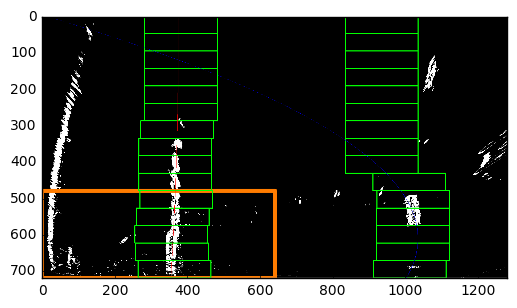

In [77]:
#plt.plot(fit_leftx, fity, color='yellow')
#plt.plot(fit_rightx, fity, color='yellow')
out_img[left_lane.getYCoords(), left_lane.getXCoords()] = [255, 0, 0]
out_img[right_lane.getYCoords(), right_lane.getXCoords()] = [0, 0, 255]

plt.imshow(out_img)

plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [ ]:
class OverlayHelper:
    
    def __init__(self, left_lane, right_lane):
        self.left_lane = left_lane
        self.right_lane = right_lane
    
    def addOverlay(self, overlay, image_BGR_car_camera_view):
        image = image_BGR_car_camera_view
        combined = np.zeros_like(image)
        cv2.addWeighted(overlay, 1, image, 0.8, 0, combined)
        return combined;
        
    def createOverlay(self, image_BGR_birds_eye_view):
        image = image_BGR_birds_eye_view
        
        overlay = np.zeros_like(image)
        pts_left_from_top_to_bottom = np.transpose(np.vstack([self.left_lane.getXCoords(), self.left_lane.getYCoords()]))
        pts_right_from_top_to_bottom = np.transpose(np.vstack([self.right_lane.getXCoords(), self.right_lane.getYCoords()]))
        
        street_polygon = self.__createPolygon(pts_left_from_top_to_bottom, pts_right_from_top_to_bottom)
        left_lane_polygon = self.__createLanePolygon(pts_left_from_top_to_bottom) 
        right_lane_polygon = self.__createLanePolygon(pts_right_from_top_to_bottom)  
        
        cv2.fillPoly(overlay, [np.int32(street_polygon)], (0,255,255))
        cv2.fillPoly(overlay, [np.int32(right_lane_polygon)], (255,0,255))
        cv2.fillPoly(overlay, [np.int32(left_lane_polygon)], (255,0,255))
                     
        return overlay
    
    def addMetadata(self, img, xm_per_pix):
        center_distance = self.__getPositionRelativeToCenter()
        center_distance = round(center_distance * xm_per_pix, 2)

        if center_distance < 0:
            text = "Car is " + str(center_distance) + " meters left of center"
        elif center_distance > 0:
            text = "Car is " + str(center_distance) + " meters left of center"
        else:
            text = "Car is " + str(center_distance) + " meters in the center"

        cv2.putText(img, text, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),3, cv2.LINE_AA)

        text = "Radius of left lane curvature is " + str(round(self.left_lane.getRadiousOfCurvatureWorldSpace(720), 0))
        cv2.putText(img, text, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),3, cv2.LINE_AA)

        text = "Radius of right lane curvature is " + str(round(self.right_lane.getRadiousOfCurvatureWorldSpace(720), 0))
        cv2.putText(img, text, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),3, cv2.LINE_AA)  
    
    def __getPositionRelativeToCenter(self, height = 720, width = 1280):
        left_lane_bottom_x = self.left_lane.getXCoord(height)
        right_lane_bottom_x = self.right_lane.getXCoord(height)
        center_point = (left_lane_bottom_x + right_lane_bottom_x)/2
        center_distance = (width/2 - center_point)
        return center_distance

    def __createPolygon(self, left_pts, right_pts):
        polygon = np.concatenate((left_pts, np.flipud(right_pts)), axis=0)                                                
        return polygon 
  
    def __createLanePolygon(self, pts, thickness = 15):
        
        # polygon left_lane
        y_coords = np.hsplit(pts, 2)[1]
        x_coords = np.hsplit(pts, 2)[0]
        x_coords_minus = x_coords - thickness
        x_coords_plus = x_coords + thickness
        pts_left = np.dstack((x_coords_minus, y_coords))
        pts_right = np.dstack((x_coords_plus, y_coords))
        
        return self.__createPolygon(pts_left, pts_right)

In [ ]:
image_BGR = cv2.imread('./test_images_perspective/test1.jpg')
ps = PixelSelection()
binary_warped = ps.detectLanePixels(image_BGR)
#binary_warped = extractWhiteAndYellow(image_BGR)
    
lf = LaneFinder(binary_warped, 15, deque(), deque(), interactiveMode = True)
left_lane, right_lane = lf.detectLanes()

out_img = lf.getOutImage()
background = np.copy(image_BGR)
    
oh = OverlayHelper(left_lane, right_lane)
overlay = oh.createOverlay(image_BGR)
combined = oh.addOverlay(overlay, image_BGR)

showImagesSideBySide(image_BGR, overlay ,"BGR2RGB", "BGR2RGB")

In [ ]:
image_BGR = cv2.imread('./test_images/test1.jpg')
warped = cv2.imread('./test_images_perspective/test1.jpg')

ps = PixelSelection()
binary_warped = ps.detectLanePixels(warped)

lf = LaneFinder(binary_warped, 15, deque(), deque(), interactiveMode = True)
left_lane, right_lane = lf.detectLanes()
    
oh = OverlayHelper(left_lane, right_lane)
overlayBirdsEyeView = oh.createOverlay(image_BGR)

pt = PerspectiveTransform()
overlayCarCameraView = pt.toCarCameraView(overlayBirdsEyeView)

combined = oh.addOverlay(overlayCarCameraView, image_BGR)
oh.addMetadata(combined, XM_PER_PIX)

showImagesSideBySide(image_BGR, combined,"BGR2RGB", "BGR2RGB")

In [ ]:
def visualizeRoadSegment(ax, image_BGR):
    
    pt = PerspectiveTransform()
    warped = pt.toBirdsEyeView(image_BGR) 
    
    ps = PixelSelection()
    binary_warped = ps.detectLanePixels(warped)

    lf = LaneFinder(binary_warped, 15, deque(), deque(), interactiveMode = True)
    left_lane, right_lane = lf.detectLanes()
    
    oh = OverlayHelper(left_lane, right_lane)
    overlayBirdsEyeView = oh.createOverlay(image_BGR)
    
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    street_overlay_birds_eye_view = oh.createOverlay(image_BGR)
    street_overlay_car_camera_view = pt.toCarCameraView(street_overlay_birds_eye_view)
    street_overlay_birds_eye_view = cv2.cvtColor(street_overlay_birds_eye_view, cv2.COLOR_BGR2RGB)
    combined = oh.addOverlay(street_overlay_car_camera_view, image_BGR)
    oh.addMetadata(combined, XM_PER_PIX)
    combined = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    
    ax[0].set_axis_off()    
    ax[0].imshow(image_RGB)
    #ax[0].set_title('Original', fontsize=20)
    
    ax[1].set_axis_off()
    ax[1].imshow(street_overlay_birds_eye_view, cmap='gray')
    #ax[1].set_title('Overlay', fontsize=20)

    ax[2].set_axis_off()
    ax[2].imshow(combined)
    #ax[2].set_title('Combined', fontsize=20)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = plt.subplots(12, 3, figsize=(20, 25))
fig.tight_layout()
visualizeRoadSegment(ax1, cv2.imread('./test_images/straight_lines1.jpg'))
visualizeRoadSegment(ax2, cv2.imread('./test_images/straight_lines2.jpg'))
visualizeRoadSegment(ax3, cv2.imread('./test_images/test1.jpg'))
visualizeRoadSegment(ax4, cv2.imread('./test_images/test2.jpg'))
visualizeRoadSegment(ax5, cv2.imread('./test_images/test3.jpg'))
visualizeRoadSegment(ax6, cv2.imread('./test_images/test4.jpg'))
visualizeRoadSegment(ax7, cv2.imread('./test_images/test5.jpg'))
visualizeRoadSegment(ax8, cv2.imread('./test_images/test6.jpg'))
visualizeRoadSegment(ax9, cv2.imread('./test_images/project-video-0.jpg'))
visualizeRoadSegment(ax10, cv2.imread('./test_images/harder_challenge_video-0.jpg'))
visualizeRoadSegment(ax11, cv2.imread('./test_images/harder_challenge_video-1.jpg'))
visualizeRoadSegment(ax12, cv2.imread('./test_images/harder_challenge_video-5.jpg'))
plt.subplots_adjust(left=0., right=0.5, top=0.9, bottom=0.)
plt.show()

In [ ]:
class ImagePipeline:
    
    def __init__(self, camera):
        self.camera = camera
        self.lastLeftLanes = deque()
        self.lastRightLanes = deque()
        
    def run(self, image_RGB):
        
        # moviepy reads in the image as RGB, but the pipeline is based on BGR
        image_BGR = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2BGR)
        
        # 1. undistort the image
        undistorted = self.camera.undistort(image_BGR)
        
        # 2. perspective transformation
        perspective = PerspectiveTransform()
        warped = perspective.toBirdsEyeView(undistorted)
        
        # 3. find potential lane pixels
        ps = PixelSelection()
        binary_warped = ps.detectLanePixels(warped)
        
        # 4. derive the lanes
        laneFinder = LaneFinder(binary_warped, 
                                15, 
                                self.lastLeftLanes, 
                                self.lastRightLanes,
                                interactiveMode = False)
        left_lane, right_lane = laneFinder.detectLanes()
          
     
        self.lastLeftLanes.append(left_lane)
        self.lastRightLanes.append(right_lane)
        if(len(self.lastLeftLanes) > 5):
            self.lastLeftLanes.popleft()
            self.lastRightLanes.popleft()
            
        # 5. create the overlay
        oh = OverlayHelper(left_lane, right_lane)
        street_overlay_birds_eye_view = oh.createOverlay(warped)
        street_overlay_car_camera_view = pt.toCarCameraView(street_overlay_birds_eye_view)
            
        # 6. combine the overlay
        combined = oh.addOverlay(street_overlay_car_camera_view, image_BGR)

        # 7. write the metadata on the image
        oh.addMetadata(combined, XM_PER_PIX)
        
        output = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
        
        return output

In [ ]:
image_BGR = cv2.imread('./test_images/test1.jpg')

ip = ImagePipeline(camera)

processed = ip.run(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))

showImagesSideBySide(image_BGR, processed, "BGR2RGB", "RGB2RGB")

In [106]:
clip = VideoFileClip("project_video.mp4")
output_video_file ="project_video_sven.mp4"
 
ip = ImagePipeline(camera)
t_start = 0.0
t_end = -26.0

if t_end > 0.0:
    clip = clip.subclip(t_start=t_start, t_end=t_end)
else:
    clip = clip.subclip(t_start=t_start)
    
#framez = clip.get_frame(13)
#framez = cv2.cvtColor(framez, cv2.COLOR_RGB2BGR)
#cv2.imwrite("challenge_video-13.jpg", framez)
#processed = ip.run(framez)
#showImagesSideBySide_BGR_BGR(framez, processed)

clip = clip.fl_image(ip.run)
clip.write_videofile(output_video_file, audio=False)

[MoviePy] >>>> Building video project_video_sven.mp4
[MoviePy] Writing video project_video_sven.mp4


100%|█████████▉| 1260/1261 [04:25<00:00,  5.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_sven.mp4 

